In [1]:
# book code
import pandas as pd
import numpy as np

np.random.seed(1)

# only show counts for these words:
words_of_interest = ['upon', 'the', 'state', 'enough', 'while']
df = pd.read_csv('federalist-papers.csv', index_col=0)
df[words_of_interest].sample(6)

,upon,the,state,enough,while
68,2,142,10,0,0
36,6,251,25,0,0
74,3,104,2,0,0
63,0,290,6,0,0
40,0,294,6,0,0
54,2,204,16,0,0


In [2]:
# essays with author 'HAMILTON OR MADISON' are the disputed essays
disputed_essays = df[df['AUTHOR'] == 'HAMILTON OR MADISON'].index
assert len(disputed_essays) == 12
assert set(disputed_essays) == {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63}

# gather essays with known authorship
df_known = df.loc[df['AUTHOR'].isin(('HAMILTON', 'MADISON'))]
print(df_known['AUTHOR'].value_counts())

AUTHOR
HAMILTON    51
MADISON     36
Name: count, dtype: int64


,upon
AUTHOR,
HAMILTON,"Axes(0.125,0.11;0.775x0.77)"
MADISON,"Axes(0.125,0.11;0.775x0.77)"


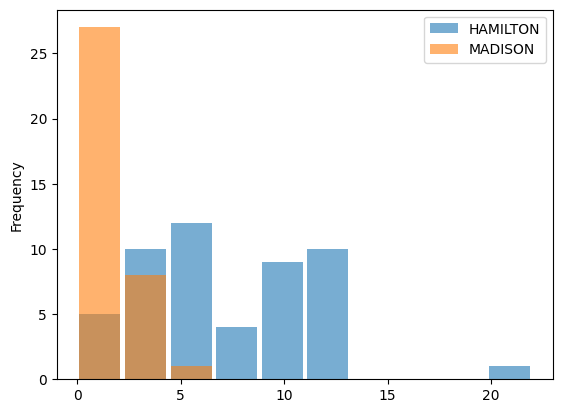

In [3]:
df_known.groupby('AUTHOR')['upon'].plot.hist(rwidth=0.9, alpha=0.6, range=(0,22), legend=True)

We can see that Hamilton uses the word "upon" far more than Madison. This could be a clue that helps attribute the essays.

In [4]:
df_known.groupby('AUTHOR')['upon'].describe()

,count,mean,std,min,25%,50%,75%,max
AUTHOR,,,,,,,,
HAMILTON,51.0,7.333333,4.008325,2.0,4.0,6.0,10.00,20.0
MADISON,36.0,1.250000,1.574348,0.0,0.0,0.5,2.25,5.0


In [5]:
proportions = df_known.groupby('AUTHOR')['upon'].apply(lambda upon_counts: (upon_counts > 0).mean())
print(proportions)

AUTHOR
HAMILTON    1.0
MADISON     0.5
Name: upon, dtype: float64


<Axes: xlabel='AUTHOR'>

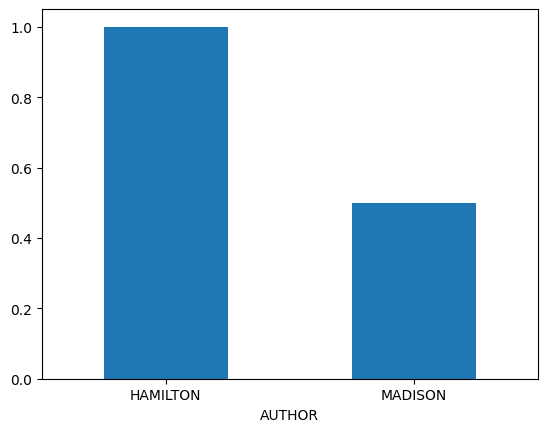

In [6]:
proportions.plot.bar(rot=0)

In [7]:
author = df['AUTHOR']
df = df.drop('AUTHOR', axis=1)
df = df.divide(df.sum(axis=0))
df *= 1000 # rate per 1000 words
df = df.round()
df['AUTHOR'] = author
df_known = df[df['AUTHOR'].isin({'HAMILTON', 'MADISON'})]

df_known.groupby('AUTHOR')['by'].describe()

,count,mean,std,min,25%,50%,75%,max
AUTHOR,,,,,,,,
HAMILTON,51.0,7.019608,4.925404,1.0,5.0,6.0,9.0,34.0
MADISON,36.0,12.916667,4.094421,5.0,10.0,12.5,15.0,23.0


,by
AUTHOR,
HAMILTON,"Axes(0.125,0.11;0.775x0.77)"
MADISON,"Axes(0.125,0.11;0.775x0.77)"


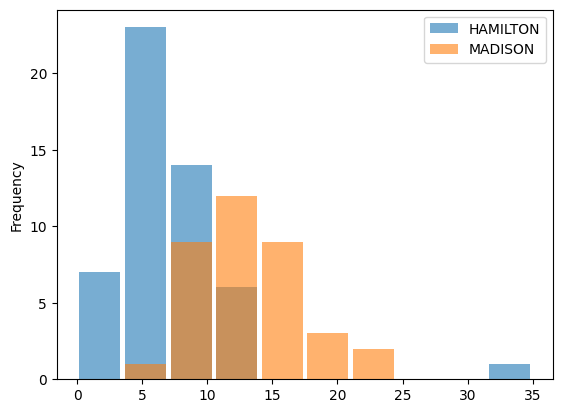

In [8]:
df_known.groupby('AUTHOR')['by'].plot.hist(alpha=0.6, range=(0,35), rwidth=0.9, legend=True)

In [9]:
print(df_known.loc[df_known['by'] > 30, 'by'])

83    34.0
Name: by, dtype: float64


In [10]:
with open('federalist-83.txt') as infile:
  text = infile.read()

by_jury_count = text.count(' by jury')
by_count = text.count(' by ')
word_count = len(text.split())
by_rate = 1000 * (by_count - by_jury_count) / word_count

print('In Federalist No 83 (by Hamilton) without "by jury", ' f'"by" occurs {by_rate:.0f} times per 1,000 words on average.')

In Federalist No 83 (by Hamilton) without "by jury", "by" occurs 7 times per 1,000 words on average.


<Axes: ylabel='Frequency'>

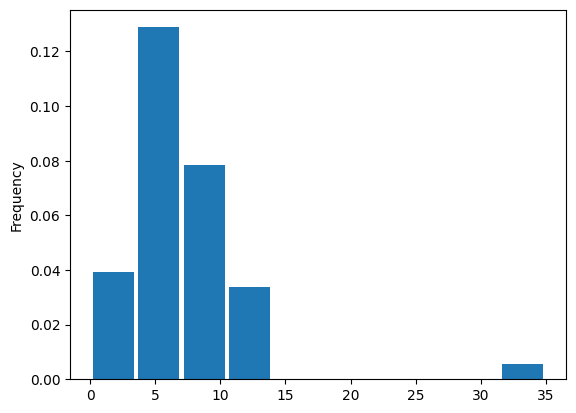

In [11]:
df_known[df_known['AUTHOR'] == 'HAMILTON']['by'].plot.hist(range=(0,35), density=True, rwidth=0.9)

In [12]:
df_known[df_known['AUTHOR'] == 'HAMILTON']['by'].describe()

,by
count,51.000000
mean,7.019608
std,4.925404
min,1.000000
25%,5.000000
50%,6.000000
75%,9.000000
max,34.000000


In [13]:
import scipy.special

def negbinom_pmf(x, alpha, beta):
  """ Negative binomial probability mass function """
  return (scipy.special.binom(x + alpha - 1, alpha - 1) * (beta / (beta + 1)) **alpha * (1 / (beta + 1)) **x)

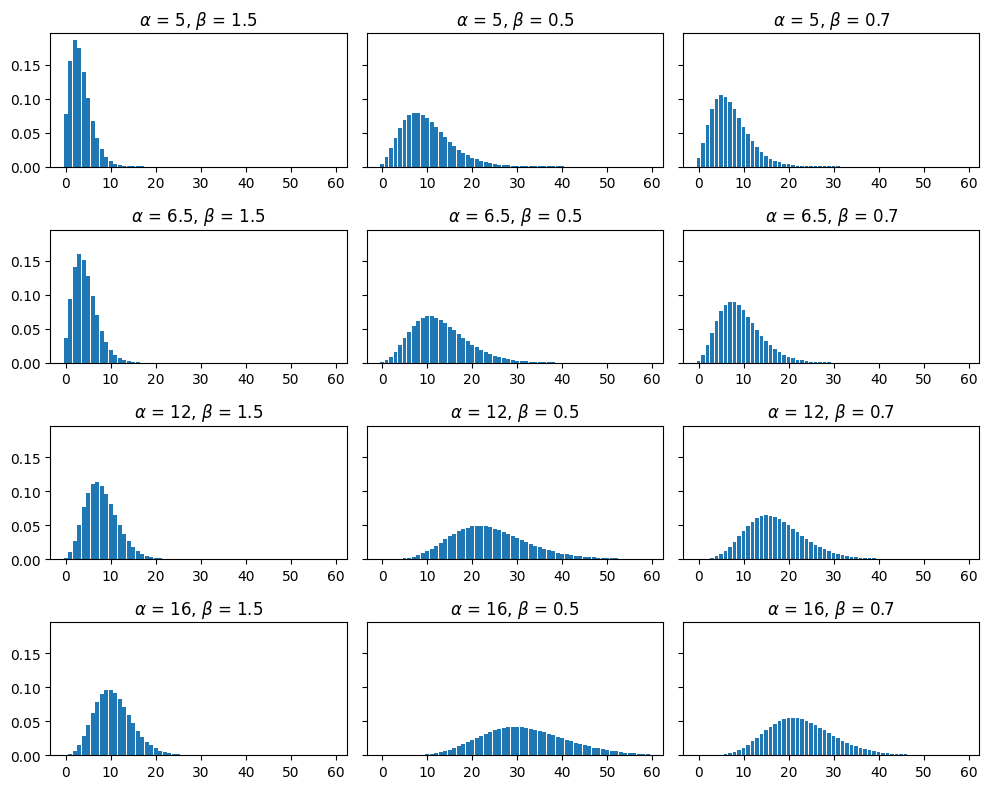

In [14]:
import itertools
import matplotlib.pyplot as plt

x = np.arange(60)
alphas, betas = [5, 6.5, 12, 16], [1.5, 0.5, 0.7]
params = list(itertools.product(alphas, betas))
pmfs = [negbinom_pmf(x, alpha, beta) for alpha, beta in params]

fig, axes = plt.subplots(4, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, pmf, (alpha, beta) in zip(axes, pmfs, params):
  ax.bar(x, pmf)
  ax.set_title(fr'$\alpha$ = {alpha}, $\beta$ = {beta}')
plt.tight_layout()

# we're trying to see what set of parameters best matches the histogram we've plotted above.
# alpha = 5, beta = 0.7 seems most similar

In [15]:
def negbinom(alpha, beta, size=None):
  """ Sample from a negative binomial distribution
  Uses np.random.negative_binomial which is different parametrization than the one in the text
  """

  n = alpha
  p = beta / (beta + 1)
  return np.random.negative_binomial(n, p, size)

In [16]:
samples = negbinom(5, 0.7, 10000)
pd.Series(samples).describe()

,0
count,10000.00000
mean,7.07620
std,4.11972
min,0.00000
25%,4.00000
50%,6.00000
75%,9.00000
max,29.00000


<Axes: ylabel='Frequency'>

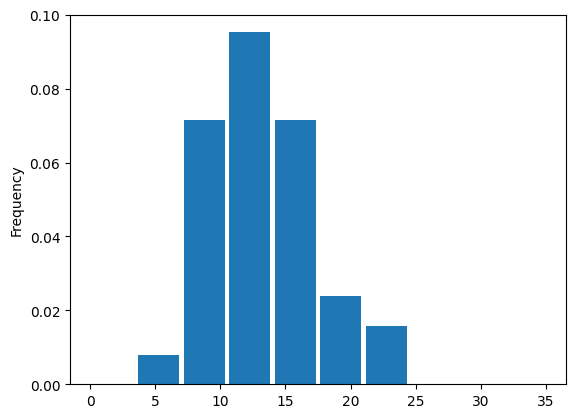

In [20]:
# let's look at Madison's use of the word "by"

df_known[df_known['AUTHOR'] == 'MADISON']['by'].plot.hist(density=True, rwidth=0.9, range=(0,35))

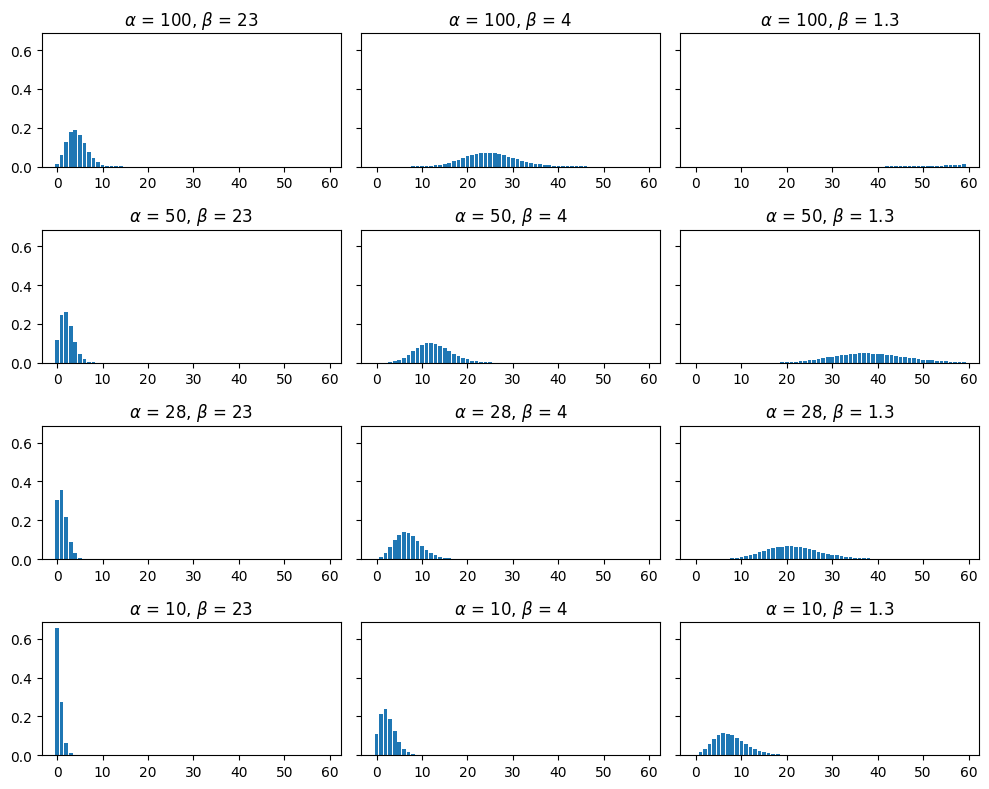

In [63]:
x = np.arange(60)
alphas, betas = [100, 50, 28, 10], [23, 4, 1.3]
params = list(itertools.product(alphas, betas))
pmfs = [negbinom_pmf(x, alpha, beta) for alpha, beta in params]

fig, axes = plt.subplots(4, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, pmf, (alpha, beta) in zip(axes, pmfs, params):
  ax.bar(x, pmf)
  ax.set_title(fr'$\alpha$ = {alpha}, $\beta$ = {beta}')
plt.tight_layout()

# we're trying to see what set of parameters best matches the histogram we've plotted above for Madison's essays
# alpha = 50, beta = 4 seems most similar

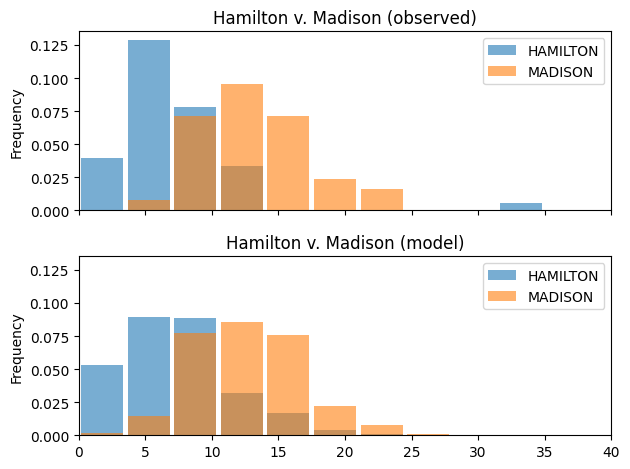

In [23]:
authors = ('HAMILTON', 'MADISON')
alpha_hamilton, beta_hamilton = 5, 0.7
alpha_madison, beta_madison = 50, 4

# observed
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
df_known.groupby('AUTHOR')['by'].plot.hist(
    ax=axes[0],
    density=True,
    range=(0,35),
    rwidth=0.9,
    alpha=0.6,
    title='Hamilton v. Madison (observed)',
    legend=True
)

# model
simulations = 10000
for author, (alpha, beta) in zip(authors, [(alpha_hamilton, beta_hamilton), (alpha_madison, beta_madison)]):
  pd.Series(negbinom(alpha, beta, size=simulations)).plot.hist(
      label=author,
      density=True,
      rwidth=0.9,
      alpha=0.6,
      range=(0,35),
      ax=axes[1])
axes[1].set_xlim((0, 40))
axes[1].set_title('Hamilton v. Madison (model)')
axes[1].legend()
plt.tight_layout()

In [24]:
likelihood_hamilton = negbinom_pmf(14, alpha_hamilton, beta_hamilton)
print(likelihood_hamilton)

0.021512065936254765


In [25]:
likelihood_madison = negbinom_pmf(14, alpha_madison, beta_madison)
print(likelihood_madison)

0.08742647980678281


In [26]:
pr_hamilton = likelihood_hamilton * 0.5 / (likelihood_hamilton * 0.5 + likelihood_madison * 0.5)
print(pr_hamilton)

0.19746973662561154


# Easy

In [34]:
# Question 4
interest = ['the', 'upon', 'enough']
df[interest]

,the,upon,enough
1,6.0,14.0,27.0
2,5.0,2.0,0.0
3,4.0,0.0,0.0
4,4.0,0.0,0.0
5,3.0,0.0,0.0
...,...,...,...
302,12.0,0.0,0.0
201,9.0,2.0,27.0
206,10.0,9.0,0.0
210,11.0,0.0,0.0


# Moderate

In [49]:
# how many times does `enough` appear in essays by hamilton and madison?
enough_ham = df_known[df_known['AUTHOR'] == 'HAMILTON']['enough']
e_ham_count = enough_ham[enough_ham > 0].count()
print("Essays by Hamilton containing 'enough'", e_ham_count)

enough_mad = df_known[df_known['AUTHOR'] == 'MADISON']['enough']
e_mad_count = enough_mad[enough_mad > 0].count()
print("Essays by Madison containing 'enough'", e_mad_count)

Essays by Hamilton containing 'enough' 17
Essays by Madison containing 'enough' 4


In [51]:
# establishing priors
# assume probability of essay written by hamilton is same as his proportion of known essays
p_h = df_known[df_known['AUTHOR'] == 'HAMILTON']['AUTHOR'].count() / len(df_known)
p_eh = e_ham_count / len(df_known[df_known['AUTHOR'] == 'HAMILTON'])
p_ehbar = e_mad_count / len(df_known[df_known['AUTHOR'] == 'MADISON'])

In [55]:
# if we learn that enough appears in the disputed essay, how does that change our belief?
# using bayes' theorem:

p_he = p_h * p_eh / (p_h * p_eh + (1 - p_h) * p_ehbar)
p_he # the essay is far more likely to be attributed to hamilton

0.8095238095238095

# Challenging

Text(0.5, 1.0, "'of's by Hamilton")

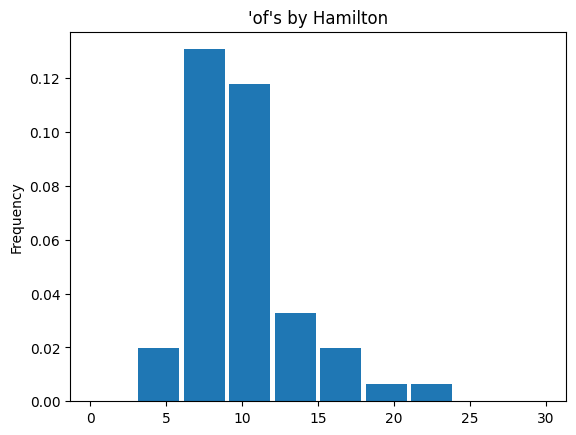

In [60]:
# Let's find the parameter of a binomial distribution for the use of "of"
df_known[df_known['AUTHOR'] == 'HAMILTON']['of'].plot.hist(range=(0,30), density=True, rwidth=0.9)
plt.title("'of's by Hamilton")

Text(0.5, 1.0, "'of's by Madison")

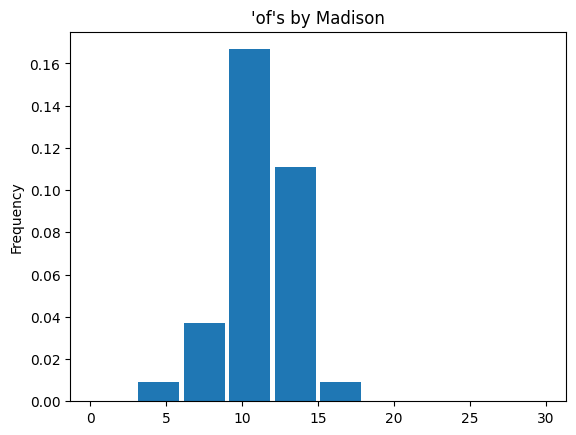

In [62]:
df_known[df_known['AUTHOR'] == 'MADISON']['of'].plot.hist(range=(0,30), density=True, rwidth=0.9)
plt.title("'of's by Madison")

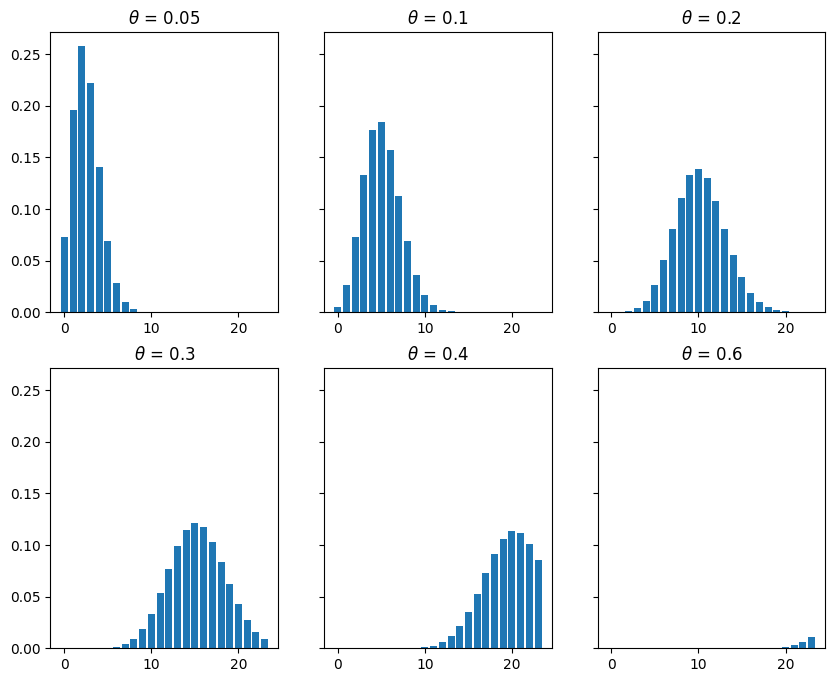

In [131]:
from scipy.stats import binom
x = np.arange(24)

n_ham = len(df_known[df_known['AUTHOR'] == 'HAMILTON'])
test_thetas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, theta in zip(axes, test_thetas):
  s = binom.pmf(x, n_ham, theta)
  ax.bar(x, s)
  ax.set_title(fr'$\theta$ = {theta}')

# theta = 0.2 case seems to be most similar to the hamilton distribution

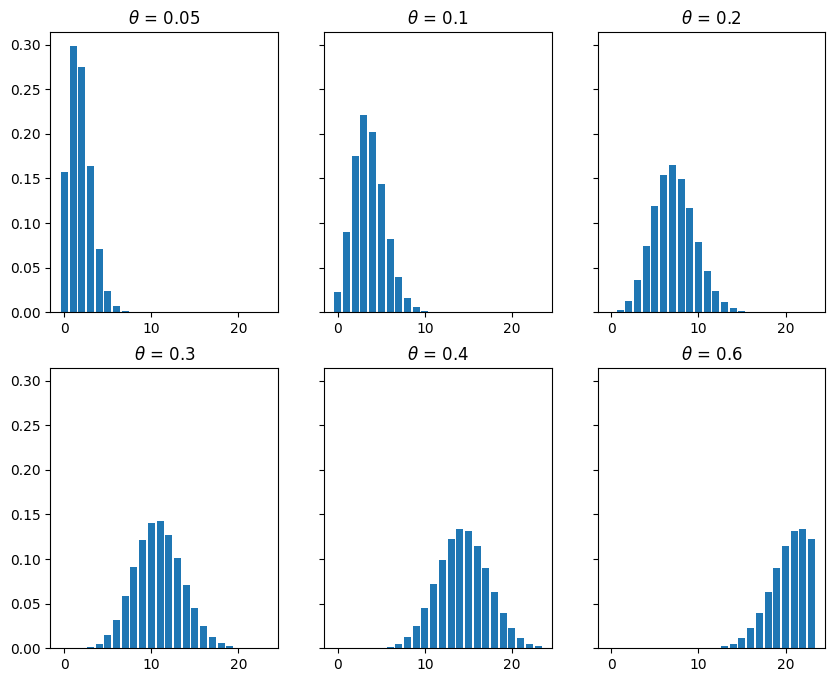

In [132]:
n_mad = len(df_known[df_known['AUTHOR'] == 'MADISON'])

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, theta in zip(axes, test_thetas):
  s = binom.pmf(x, n_mad, theta)
  ax.bar(x, s)
  ax.set_title(fr'$\theta$ = {theta}')

# theta = 0.3 case seems to be most similar to the madison distribution

In [138]:
# establishing priors, given that "of" is observed 8 times in the essay
likelihood_madison = binom.pmf(8, n_mad, 0.2)
likelihood_hamilton = binom.pmf(8, n_ham, 0.2)

pr_hamilton = (likelihood_hamilton * p_h) / ((likelihood_hamilton * p_h) + likelihood_madison * (1 - p_h))
pr_hamilton

0.5119260097468497

Given that the word "of" appears 8 times, it is slightly more likely that the essay was written by Hamilton than Madison.